<a href="https://colab.research.google.com/github/rubyhung0529/Thesis/blob/main/%E6%B7%A1%E6%B0%B4%E6%B2%B3Modeling_20210127(ML%E6%96%B9%E6%B3%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import numpy as np
from tqdm import tqdm_notebook as tqdm
pd.options.display.float_format = '{:.4f}'.format#評分分數不要科學記號,到小數點後三位
seed = 42
np.random.seed(seed)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
full = pd.read_csv('/content/drive/My Drive/碩士論文資料/淡水河流域_cleaned(full).csv').sort_values(by='採樣日期')
full = pd.DataFrame(full)
print(full.shape)
full.head()

(2239, 24)


,測站名稱,採樣日期,河川污染指數,氣溫,水溫,酸鹼值,導電度,溶氧(電極法),溶氧飽和度,生化需氧量,化學需氧量,懸浮固體,大腸桿菌群,氨氮,總磷,硝酸鹽氮,鎘,鉛,六價鉻,砷,汞,銅,鋅,錳
998,板新取水口,2005-03-01 01:30:00,2.3000,13.2000,14.1000,8.1000,247.0000,10.0000,97.5000,1.0000,5.5000,54.3000,4200.0000,0.1100,0.0270,0.5400,0.0010,0.0330,0.0060,0.0012,0.0005,0.0050,0.0210,0.1220
921,暖江橋,2005-03-01 01:44:00,1.5000,17.5000,16.4000,6.6000,144.0000,10.8000,109.8000,2.0000,6.6000,42.1000,17000.0000,0.3500,0.0160,0.7600,0.0010,0.0120,0.0060,0.0014,0.0005,0.0050,0.0790,0.0790
1001,三鶯大橋,2005-03-01 02:20:00,2.3000,13.0000,14.9000,8.0000,201.0000,10.0000,99.5000,1.0000,4.8000,58.9000,2200.0000,0.0800,0.0140,0.5200,0.0010,0.0140,0.0040,0.0009,0.0003,0.0050,0.0300,0.1190
924,六合橋,2005-03-01 02:36:00,2.3000,16.5000,15.9000,6.4000,266.0000,10.0000,100.9000,2.3000,11.6000,92.2000,43000.0000,0.3600,0.0190,0.9700,0.0010,0.0170,0.0030,0.0010,0.0013,0.0090,0.0610,0.1390
987,三峽河抽水站(取代醒心橋),2005-03-01 03:10:00,1.0000,12.5000,14.4000,7.5000,113.0000,10.1000,98.9000,1.0000,5.6000,16.6000,2400.0000,0.0800,0.0140,1.1400,0.0010,0.0100,0.0070,0.0013,0.0011,0.0030,0.0290,0.0420


# define X,y

In [3]:
col = full.columns.tolist()
x_col = col[2:12]
y_col = ['大腸桿菌群','氨氮','總磷','砷','錳']
x_col,y_col

(['河川污染指數',
  '氣溫',
  '水溫',
  '酸鹼值',
  '導電度',
  '溶氧(電極法)',
  '溶氧飽和度',
  '生化需氧量',
  '化學需氧量',
  '懸浮固體'],
 ['大腸桿菌群', '氨氮', '總磷', '砷', '錳'])

# scaled

In [4]:
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
full[x_col] = ss_x.fit_transform(full[x_col])
full[y_col] = ss_y.fit_transform(full[y_col])
full.head()

,測站名稱,採樣日期,河川污染指數,氣溫,水溫,酸鹼值,導電度,溶氧(電極法),溶氧飽和度,生化需氧量,化學需氧量,懸浮固體,大腸桿菌群,氨氮,總磷,硝酸鹽氮,鎘,鉛,六價鉻,砷,汞,銅,鋅,錳
998,板新取水口,2005-03-01 01:30:00,-0.2499,-1.8174,-1.8293,1.3239,-0.2048,1.0956,0.5661,-0.4758,-0.4337,-0.0255,-0.2295,-0.6466,-0.6323,0.5400,0.0010,0.0330,0.0060,-0.0082,0.0005,0.0050,0.0210,0.1103
921,暖江橋,2005-03-01 01:44:00,-0.6494,-1.1234,-1.3416,-2.2729,-0.2246,1.3649,0.9272,-0.2630,-0.3640,-0.0472,-0.2123,-0.5181,-0.6686,0.7600,0.0010,0.0120,0.0060,0.0964,0.0005,0.0050,0.0790,-0.0480
1001,三鶯大橋,2005-03-01 02:20:00,-0.2499,-1.8497,-1.6596,1.0841,-0.2137,1.0956,0.6248,-0.4758,-0.4780,-0.0173,-0.2322,-0.6627,-0.6752,0.5200,0.0010,0.0140,0.0040,-0.1652,0.0003,0.0050,0.0300,0.0992
924,六合橋,2005-03-01 02:36:00,-0.2499,-1.2848,-1.4476,-2.7525,-0.2011,1.0956,0.6659,-0.1992,-0.0473,0.0418,-0.1773,-0.5127,-0.6587,0.9700,0.0010,0.0170,0.0030,-0.1129,0.0013,0.0090,0.0610,0.1729
987,三峽河抽水站(取代醒心橋),2005-03-01 03:10:00,-0.8991,-1.9304,-1.7657,-0.1148,-0.2306,1.1292,0.6072,-0.4758,-0.4273,-0.0925,-0.2319,-0.6627,-0.6752,1.1400,0.0010,0.0100,0.0070,0.0441,0.0011,0.0030,0.0290,-0.1842


# prepare data and forward test

In [5]:
def create_inout_sequences(input_data,t):
  x = []
  y = []
  for i in range(len(input_data)-t):
    x.append(input_data.iloc[i:i+t][x_col+y_col].values)
    y.append(input_data.iloc[[i+t]][y_col].values)
    #y.append(input_data.iloc[[i+t-1]][y_col].values)
  return np.array(x),np.array(y)

X,Y = create_inout_sequences(full,t=3)
X.shape,Y.shape

((2236, 3, 15), (2236, 1, 5))

# modeling

In [6]:
def fit_and_return_predction(model,X,y):
  '''
  0. flatten data
  1. split data
  2. fit on train
  3. store prediction
  4. return prediction
  '''
  
  # 0 flatten
  batch_size = X.shape[0]
  X = X.reshape(batch_size,-1)
  y = y.reshape(batch_size,-1)

  # 1 split data train,test
  sp = int(len(X)*0.8)
  X_train = X[:sp]
  y_train = y[:sp]
  X_test = X[sp:]
  y_test = y[sp:]
  
  # 2. fit model on train data
  model.fit(X_train,y_train)
  
  # 3. store prediction to result dict
  result = {}

  # predict 
  result['train_pred'] = pd.DataFrame(deepcopy(y_train),columns=y_col)
  result['test_pred'] = pd.DataFrame(deepcopy(y_test),columns=y_col)
  result['train_pred'][:] = pd.DataFrame(model.predict(X_train),columns=y_col)
  result['test_pred'][:] = pd.DataFrame(model.predict(X_test),columns=y_col)
  
  # add real data
  result['X_train'] = deepcopy(X_train)
  result['y_train'] = pd.DataFrame(deepcopy(y_train),columns=y_col)
  result['X_test'] = deepcopy(X_test)
  result['y_test'] = pd.DataFrame(deepcopy(y_test),columns=y_col)
  
  #4. return prediction
  return result

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from copy import deepcopy
import joblib

LR_model = MultiOutputRegressor(LinearRegression())
RF_model = MultiOutputRegressor(RandomForestRegressor(max_depth=5,n_estimators=200))

LR_result = fit_and_return_predction(LR_model,X,Y)
RF_result = fit_and_return_predction(RF_model,X,Y)

# save for plotting
plot_data = {}
plot_data['LR'] = LR_result
plot_data['RF'] = RF_result
save_path = '/content/drive/My Drive/碩士論文資料/plot_data.pkl'
joblib.dump(plot_data,save_path)

['/content/drive/My Drive/碩士論文資料/plot_data.pkl']

# metric

In [8]:
from math import sqrt
def MAPE(a, b): 
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return abs((np.fabs(a - b)/a)[mask].mean()*100)

def metric(y_pred,y_real):
  score = pd.DataFrame(index=['大腸桿菌群','氨氮','總磷','砷','錳'],columns=['R2','MSE','MAPE'])
  for i in ['大腸桿菌群','氨氮','總磷','砷','錳']:
    score.loc[i,'R2'] = max(round(r2_score(y_real[i],y_pred[i]),4),0)
    score.loc[i,'MSE'] = round(mean_squared_error(y_real[i],y_pred[i]),4)
    score.loc[i,'MAPE'] = round(MAPE(y_real[i],y_pred[i]),4)
  score.loc['AVG'] = score.mean(axis=0)
  return score

In [9]:
y_pred = LR_result['test_pred']
y_real = LR_result['y_test']
metric(y_pred,y_real)

,R2,MSE,MAPE
大腸桿菌群,0,0.3044,38.9852
氨氮,0.3465,0.3175,40.1650
總磷,0,0.2455,126.3133
砷,0,0.1517,99.5473
錳,0,0.0839,403.7619
AVG,0.0693,0.2206,141.7545


In [10]:
y_pred = RF_result['test_pred']
y_real = RF_result['y_test']
metric(y_pred,y_real)

,R2,MSE,MAPE
大腸桿菌群,0,0.2751,35.1057
氨氮,0.2475,0.3656,101.3436
總磷,0,0.2512,116.8565
砷,0.0598,0.1095,61.7476
錳,0,0.0411,51.0912
AVG,0.0615,0.2085,73.2289


大腸桿菌群


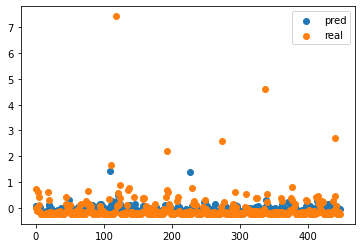

氨氮


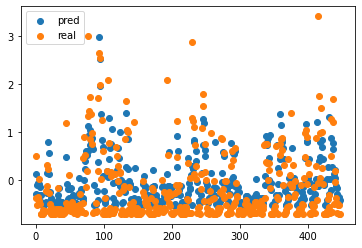

總磷


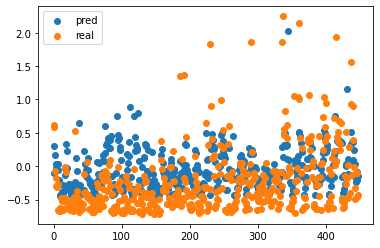

砷


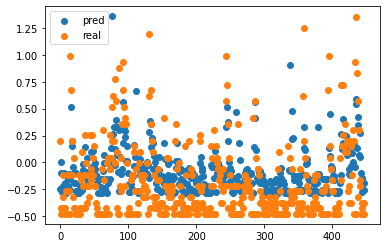

錳


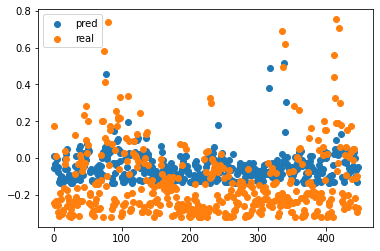

In [11]:
import matplotlib.pyplot as plt
for name in ['大腸桿菌群','氨氮','總磷','砷','錳']:
  print(name)
  plt.scatter(y_pred[name].index,y_pred[name],label='pred')
  plt.scatter(y_real[name].index,y_real[name],label='real')
  plt.legend()
  plt.show()